In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.optimize import curve_fit
import numpy as np
import cv2
import os

### 1. Calibration Films - Intensity extraction

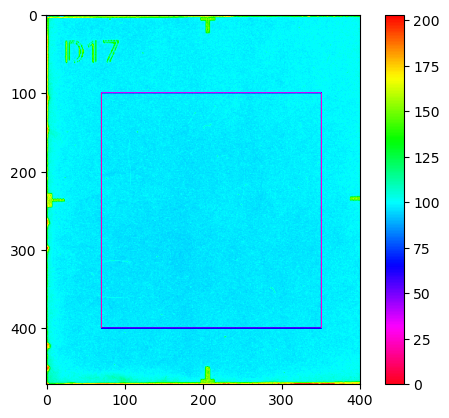

  Mean intensity square :  97.03513095238095


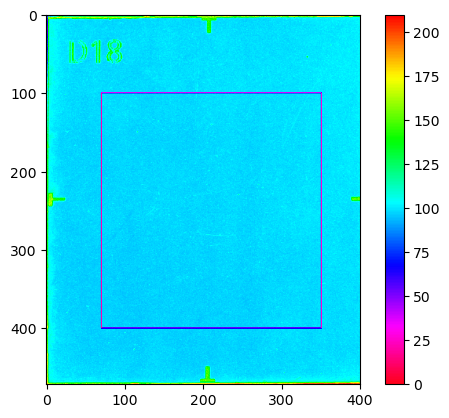

  Mean intensity square :  98.12238095238095


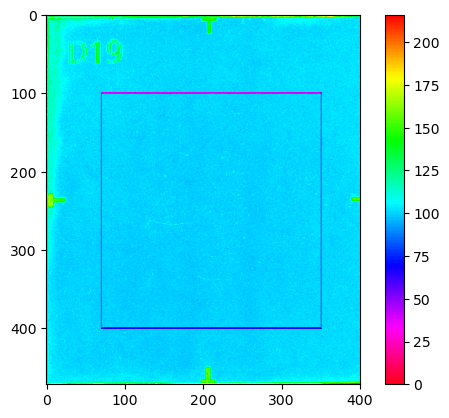

  Mean intensity square :  100.0364880952381


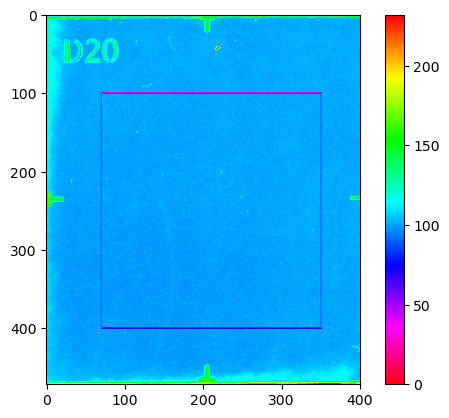

  Mean intensity square :  100.19548809523809


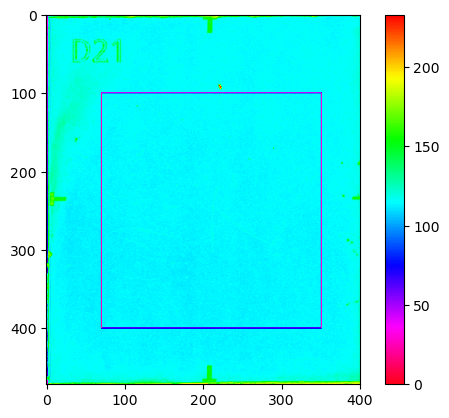

  Mean intensity square :  113.75864285714286


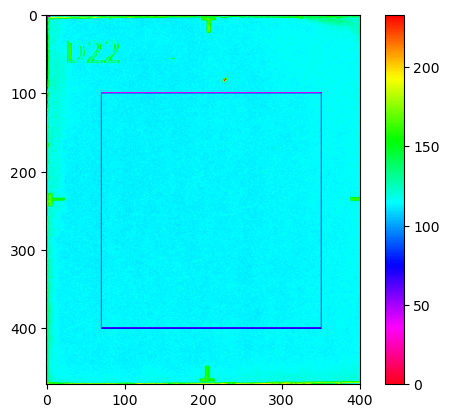

  Mean intensity square :  113.33153571428572


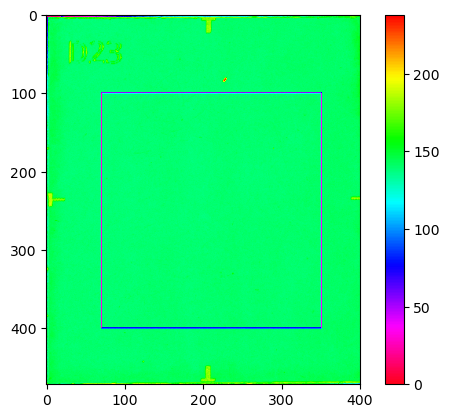

  Mean intensity square :  139.92220238095237


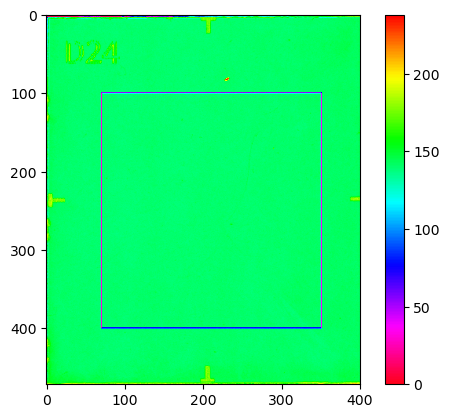

  Mean intensity square :  140.35403571428571


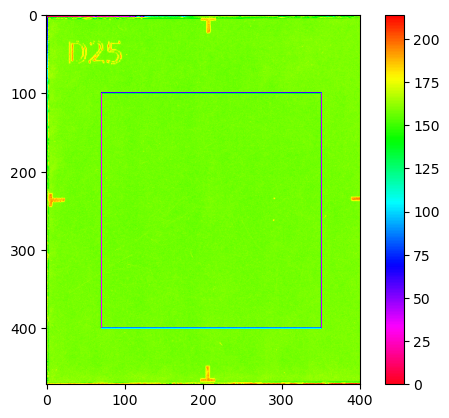

  Mean intensity square :  157.4950357142857


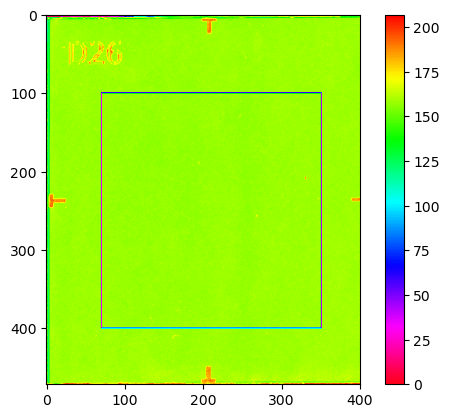

  Mean intensity square :  157.62911904761904


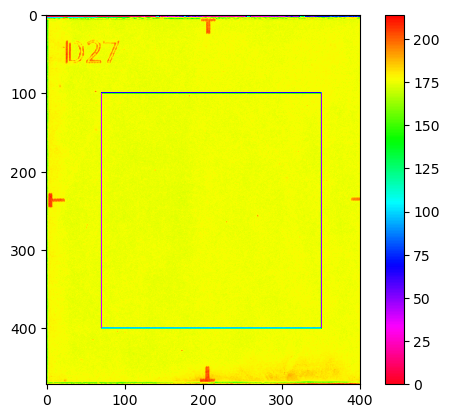

  Mean intensity square :  175.16083333333333


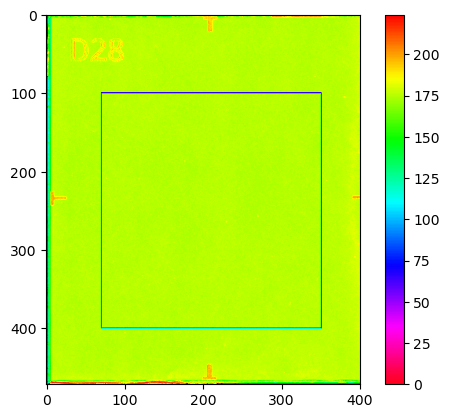

  Mean intensity square :  175.02710714285715


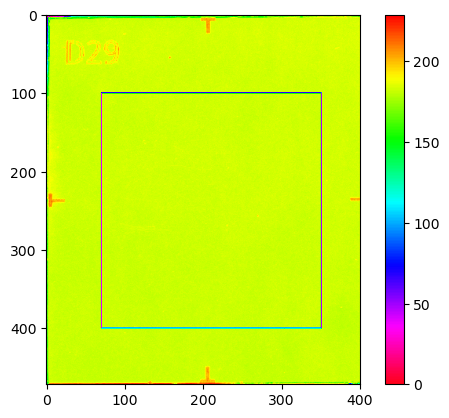

  Mean intensity square :  182.5592619047619


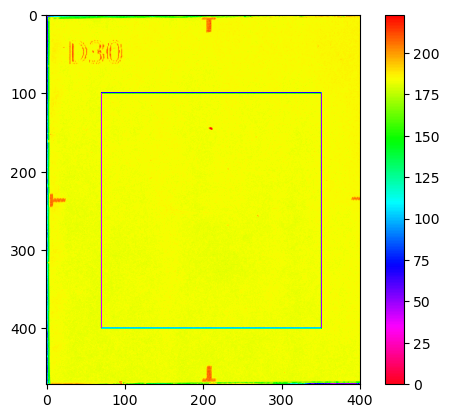

  Mean intensity square :  183.04975


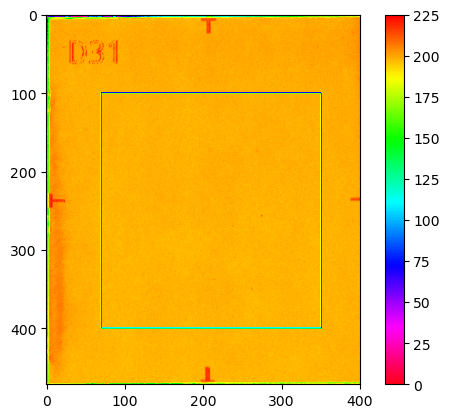

  Mean intensity square :  198.06016666666667


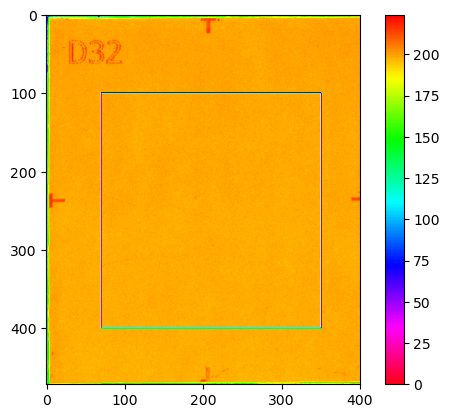

  Mean intensity square :  198.40479761904763


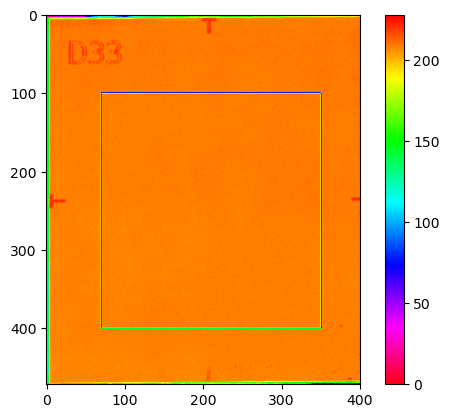

  Mean intensity square :  208.4497738095238


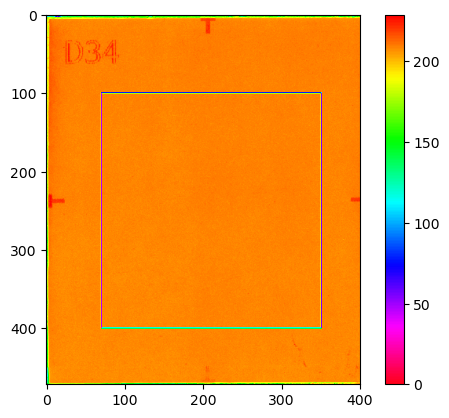

  Mean intensity square :  208.54675


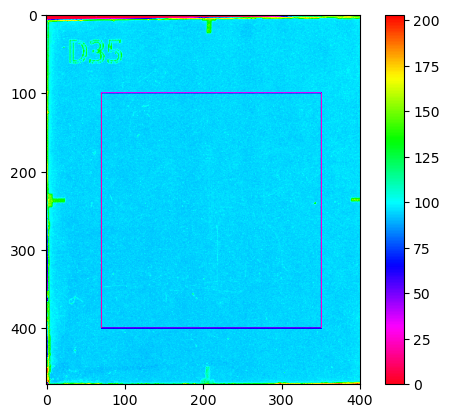

  Mean intensity square :  94.36064285714286


In [2]:
I = []
n=0

filenames = np.sort(os.listdir(f"HUG_study_2/calibration_HUG"))

with open("HUG_study_2/calibration_intensity_HUG.txt", "w") as text_file:                   
    text_file.write("Film \t        Intensity \n")                                           
    
    for i in filenames:                                                                     
        file = f'HUG_study_2/calibration_HUG/{i}'
        column0 = i.replace(".tif", "")
        
        image = cv2.imread(file)
        image_g = image[:,:,1]
                            
        negative_image = cv2.bitwise_not(image_g)                                          
                                                                                            

        x, y, width, height = 70, 100, 280, 300                   
        square = negative_image[y:y+height, x:x+width]                                     
        mean_intensity = np.mean(square)    
        
        I.append(mean_intensity)
        
        result = cv2.rectangle(negative_image, (x,y), (x+width, y+height), (0,0,0), 1)
        
        plt.figure()
        plt.imshow(result, cmap="hsv_r")
        plt.colorbar()
        plt.show()                         
        
        line = f"{column0}\t{I[n]}\n"
        
        text_file.write(line)
         
        n+=1
        
        print(" \033[1m Mean intensity square : \033[0m", mean_intensity)

## 2. Calibration Curve 


### 2.1 OD calculation

In [3]:
I = np.loadtxt("HUG_study_2/intensity_calibration.txt")
I_ = np.sort(I)


OD = []

def ItoOD(x):
    return abs(np.log(min(I_)/x))

for i in I_:
    OD.append(ItoOD(i))

print(OD)

[0.0, 0.03353573791928923, 0.059205327485118225, 0.18507595322795417, 0.39550443319962164, 0.5126954554735754, 0.6181987350160681, 0.6612932412461443, 0.7423164265766616, 0.7928066376323859]


### 2.2 Calibration with calculated OD

**Fit model such as :** $$ D(OD) = \frac{a - c e^{-OD}}{e^{-OD}-b}$$

 fit parameters:  a = 2.997255079687354, b = 0.37229180737417733, c = 3.05954080625352


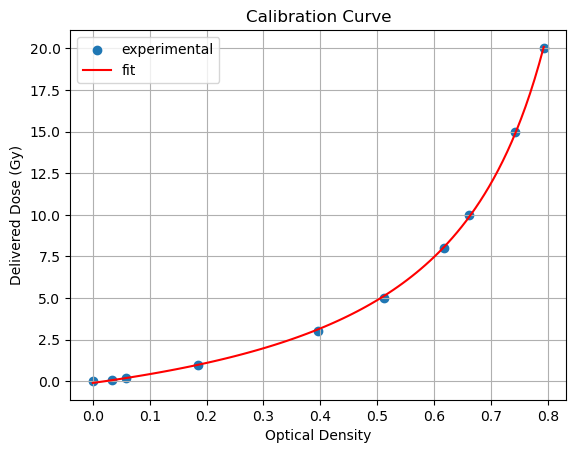

In [4]:
dose_data = np.sort(np.loadtxt("HUG_study_2/calibration_dose.txt"))

interval = np.linspace(min(OD), max(OD), 100)

def D(x, a, b, c):
    return (a-c*np.exp(-x))/(np.exp(-x)-b)

popt, pcov = curve_fit(D, OD, dose_data, (0, 0, 0), maxfev = 10000)

a, b, c = popt

plt.scatter(OD, dose_data, label='experimental')
plt.plot(interval, D(interval, *popt), label="fit", color="red")
plt.xlabel('Optical Density')
plt.ylabel('Delivered Dose (Gy)')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
print(f"\033[1m fit parameters: \033[0m a = {a}, b = {b}, c = {c}")
plt.show()

## 3. Dose Measurement 

### 3.1 Eppendorf with Mercury to locate the sample

 Mean intensity square :  189.58833333333334 

 Mean dose square :  11.76 Gy 



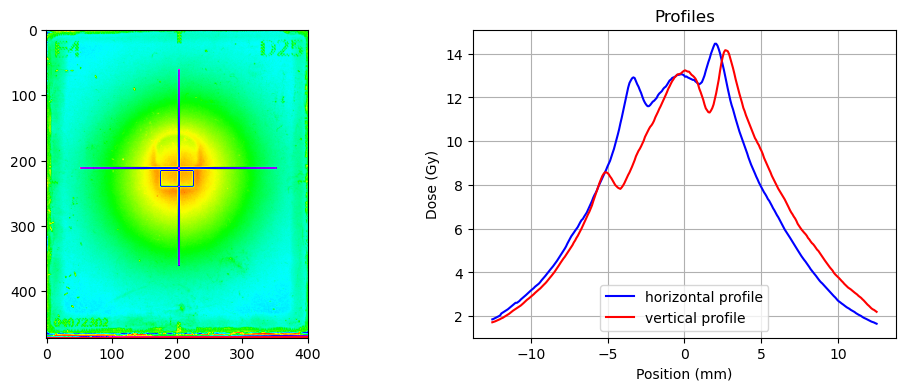

In [9]:
file = f'HUG_study_2/ZFE_D/D025.tif'

image = cv2.imread(file)
image_g = image[:, :, 1]

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

negative_image = cv2.bitwise_not(image_g)

#Gaussian blur to locate maximum intensity pixel

image_blur = cv2.GaussianBlur(negative_image, (7, 7), 0)

x_zoi, y_zoi = 200, 210

zoi = image_blur[y_zoi:220, x_zoi:220]

(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(zoi)

maxLoc_x = maxLoc[0] + x_zoi
maxLoc_y = maxLoc[1] + y_zoi

#square centered on the max pixel

x, y, width, height = 175, 215, 50, 24
#x, y, width, height = maxLoc_x-6, maxLoc_y-6, 12, 12

area = negative_image[y:y+height, x:x+width]

mean_intensity = np.mean(area)


#horizontal slice
x_hor, y_hor, width_hor, height_hor = maxLoc_x-150, maxLoc_y, 300, 2
hor =  negative_image[y_hor:y_hor+height_hor, x_hor:x_hor+width_hor]

#vertical slice
x_ver, y_ver, width_ver, height_ver = maxLoc_x, maxLoc_y-150, 2, 300
ver =  negative_image[y_ver:y_ver+height_ver, x_ver:x_ver+width_ver]

print("\033[1m Mean intensity square : \033[0m", mean_intensity, "\n")
print("\033[1m Mean dose square : \033[0m", round(D(ItoOD(mean_intensity), *popt), 2), "Gy \n")
#print(f"({maxLoc_x}, {maxLoc_y}): {round(D(ItoOD(maxVal), *popt), 2)} Gy")

#vertical and horizontal intensity per pixel length

ver_intensity = []
hor_intensity = []  

for i in range(1,height_ver):
    ver_intensity.append(np.mean(negative_image[y_ver+i:y_ver+i+12, x_ver:x_ver+width_ver]))
    
for i in range(1,width_hor):
    hor_intensity.append(np.mean(negative_image[y_hor:y_hor+height_hor, x_hor+i:x_hor+i+12])) 


ver_dose = []
hor_dose = []

    
for i in range(1, height_ver-1):
    ver_dose.append(D(ItoOD(ver_intensity[i]), *popt))

for i in range(1,width_hor-1) :
    hor_dose.append(D(ItoOD(hor_intensity[i]), *popt))


result = cv2.rectangle(negative_image, (x,y), (x+width, y+height), (0,255,0), 1)
result_hor = cv2.rectangle(negative_image, (x_hor,y_hor), (x_hor+width_hor, y_hor+height_hor), (0,255,0), 1)
result_ver = cv2.rectangle(negative_image, (x_ver,y_ver), (x_ver+width_ver, y_ver+height_ver), (0,255,0), 1)

#Gaussian fit and display

interval = np.linspace(-width_hor/2, width_hor/2, width_hor-2)
interval_mm = interval / 12.0  # Conversion en millimètres


def gauss(x, a, sigma, mu):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

#popt_hor, pcov_hor = curve_fit(gauss, interval_mm, hor_dose)
#a_hor, sigma_hor, mu_hor = popt_hor

fig, axs = plt.subplots(1,2, figsize=(12, 4))
axs = axs.ravel()

axs[0].imshow(result, cmap="hsv_r")

axs[1].plot(interval_mm, hor_dose, color="blue", label="horizontal profile")
#axs[1].plot(interval_mm, gauss(interval_mm, *popt_hor), "green",  label="hor gaussian fit")
axs[1].plot(interval_mm, ver_dose, color="red",  label="vertical profile")
axs[1].set_xlabel("Position (mm)")
axs[1].set_ylabel("Dose (Gy)")
axs[1].set_title("Profiles")
axs[1].grid(True)
axs[1].legend()
#print(f"\033[1m fit parameters: \033[0m a = {round(a_hor, 2)} Gy, sigma = {round(sigma_hor, 2)} mm, mu = {round(mu_hor, 2)}")
plt.show()

## 3.2 Dose measurement of whole batch

**See txt file attached for listed dose values**

 Mean dose square :  8.09 Gy
 fit parameters hor:  a = 9.27 Gy, sigma = -3.64 mm, mu = -1.17 

 fit parameters ver:  a = 9.47 Gy, sigma = -3.73 mm, mu = -0.11 



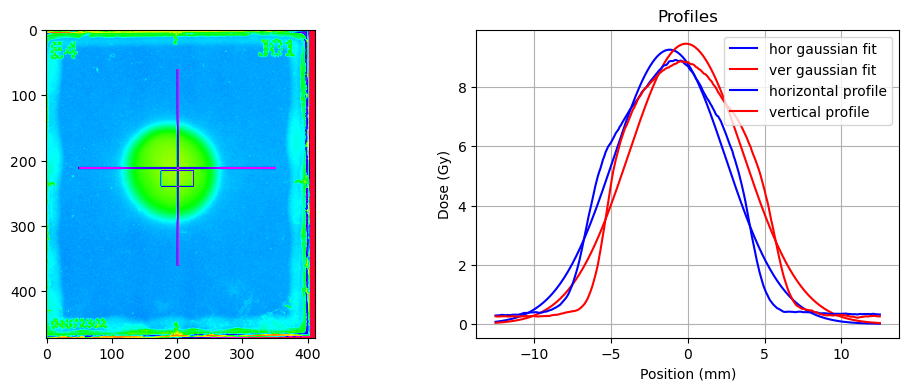

 Mean dose square :  8.36 Gy
 fit parameters hor:  a = 9.4 Gy, sigma = -3.65 mm, mu = -1.05 

 fit parameters ver:  a = 9.57 Gy, sigma = -3.8 mm, mu = 0.29 



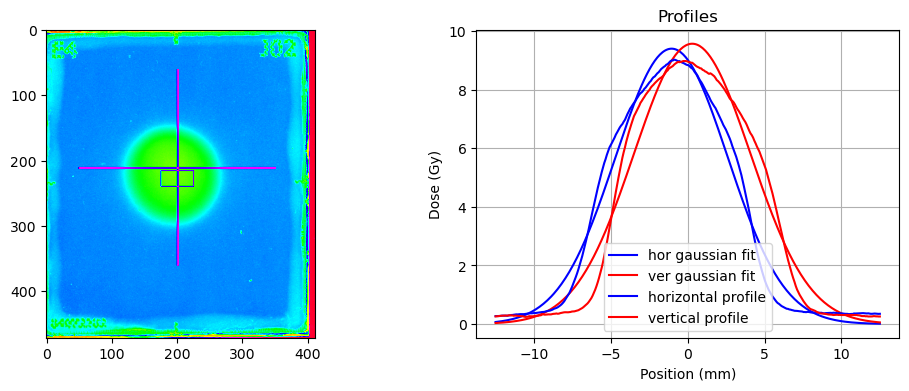

 Mean dose square :  8.53 Gy
 fit parameters hor:  a = 9.58 Gy, sigma = -3.56 mm, mu = -0.92 

 fit parameters ver:  a = 9.92 Gy, sigma = -3.71 mm, mu = -0.89 



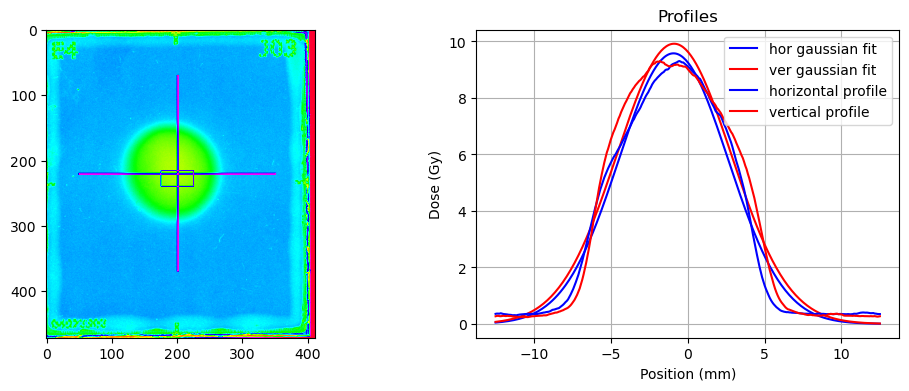

 Mean dose square :  8.41 Gy
 fit parameters hor:  a = 9.55 Gy, sigma = -3.6 mm, mu = -0.99 

 fit parameters ver:  a = 9.68 Gy, sigma = -3.75 mm, mu = -0.01 



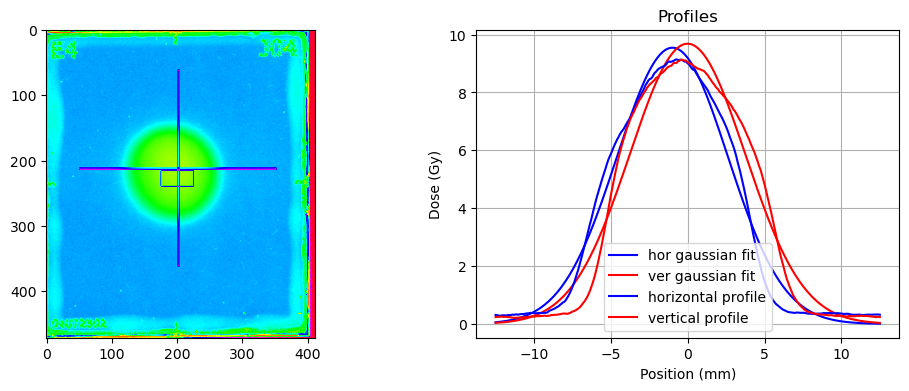

 Mean dose square :  8.25 Gy
 fit parameters hor:  a = 9.36 Gy, sigma = -3.59 mm, mu = -0.95 

 fit parameters ver:  a = 9.61 Gy, sigma = -3.72 mm, mu = -0.07 



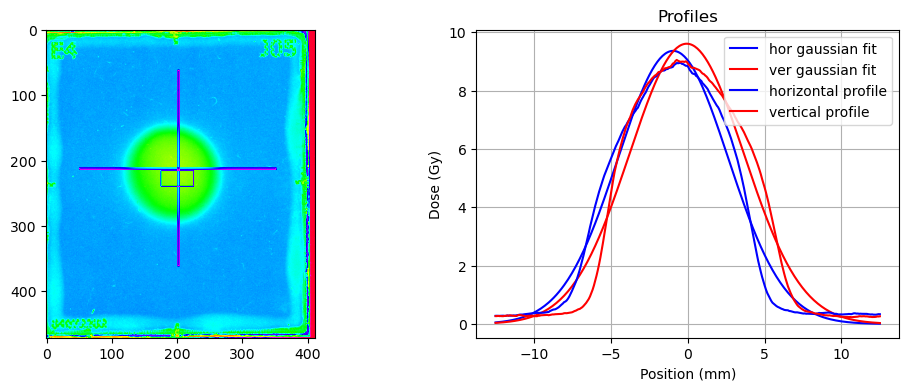

 Mean dose square :  8.33 Gy
 fit parameters hor:  a = 9.36 Gy, sigma = -3.61 mm, mu = -0.97 

 fit parameters ver:  a = 9.65 Gy, sigma = -3.77 mm, mu = 0.12 



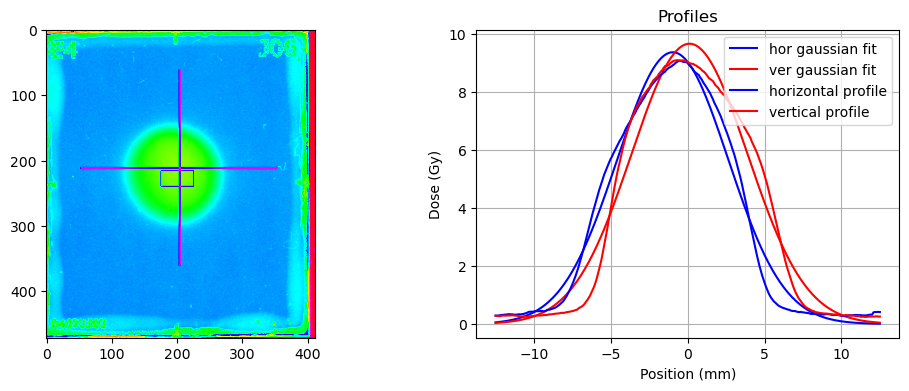

 Mean dose square :  10.81 Gy
 fit parameters hor:  a = 12.18 Gy, sigma = 3.58 mm, mu = -1.28 

 fit parameters ver:  a = 12.29 Gy, sigma = 3.7 mm, mu = 0.13 



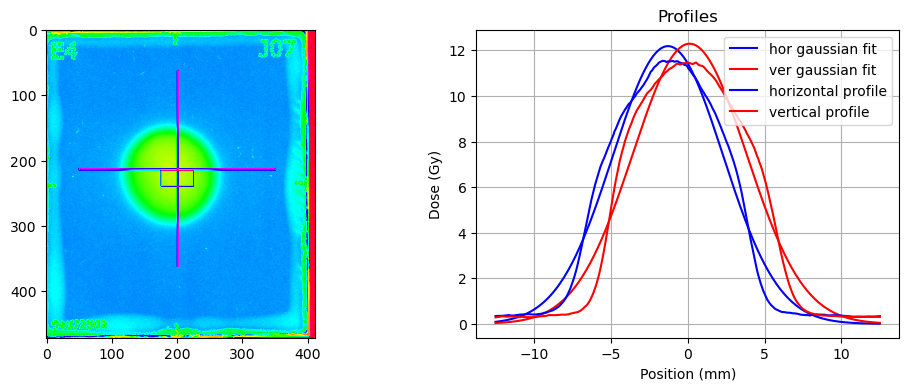

 Mean dose square :  10.45 Gy
 fit parameters hor:  a = 11.77 Gy, sigma = 3.57 mm, mu = -1.14 

 fit parameters ver:  a = 11.9 Gy, sigma = 3.76 mm, mu = 0.17 



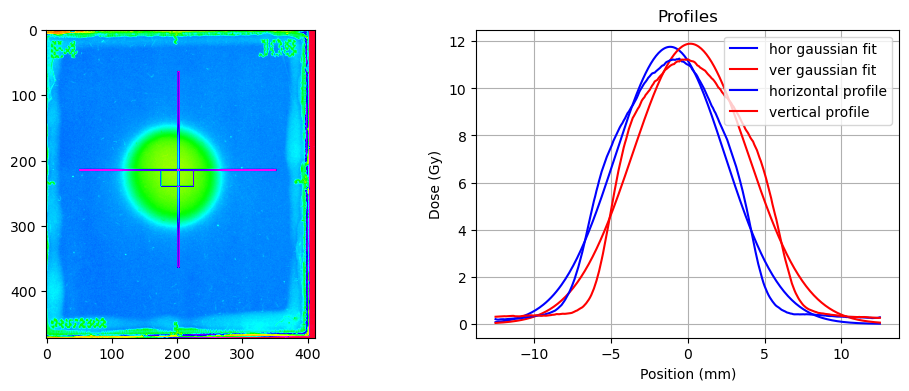

 Mean dose square :  10.03 Gy
 fit parameters hor:  a = 11.48 Gy, sigma = 3.6 mm, mu = -1.02 

 fit parameters ver:  a = 11.64 Gy, sigma = 3.75 mm, mu = -0.42 



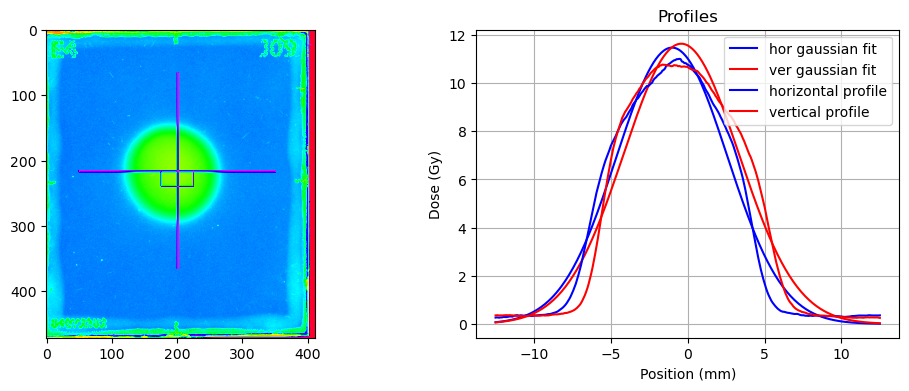

 Mean dose square :  10.14 Gy
 fit parameters hor:  a = 11.29 Gy, sigma = 3.63 mm, mu = -0.91 

 fit parameters ver:  a = 11.56 Gy, sigma = 3.82 mm, mu = 0.41 



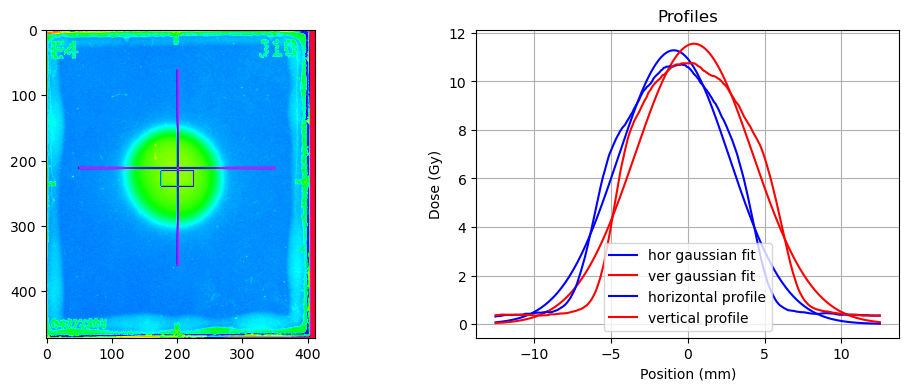

 Mean dose square :  10.84 Gy
 fit parameters hor:  a = 12.52 Gy, sigma = 3.54 mm, mu = -1.48 

 fit parameters ver:  a = 12.47 Gy, sigma = 3.69 mm, mu = 0.03 



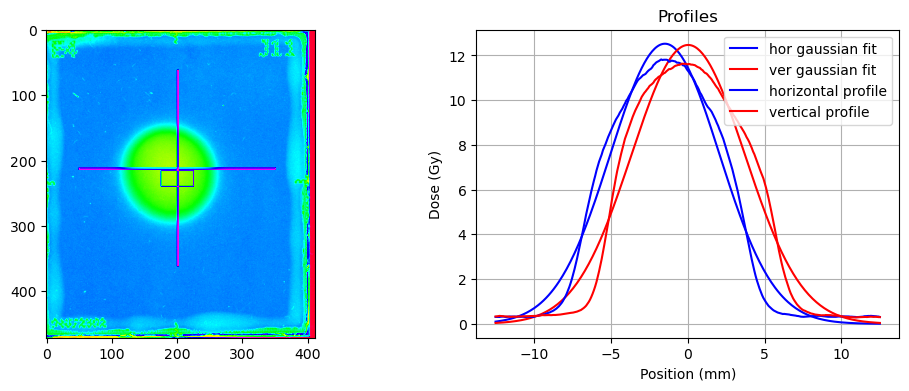

 Mean dose square :  11.24 Gy
 fit parameters hor:  a = 12.78 Gy, sigma = 3.57 mm, mu = -1.36 

 fit parameters ver:  a = 12.84 Gy, sigma = 3.74 mm, mu = -0.1 



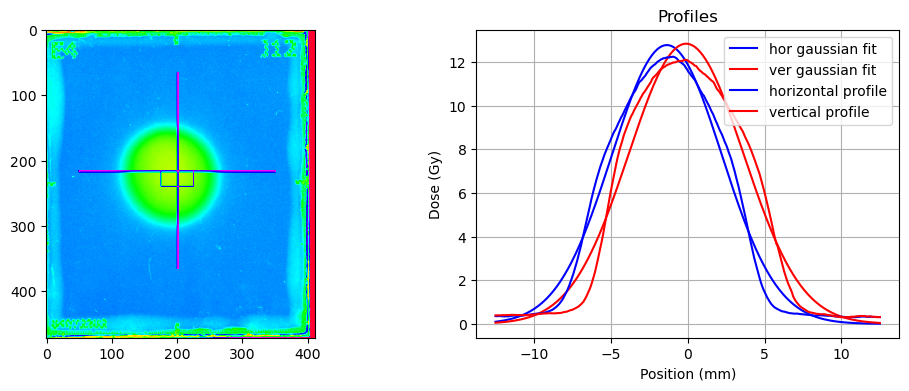

 Mean dose square :  8.64 Gy
 fit parameters hor:  a = 9.89 Gy, sigma = 3.94 mm, mu = -2.04 

 fit parameters ver:  a = 9.86 Gy, sigma = 4.03 mm, mu = 0.97 



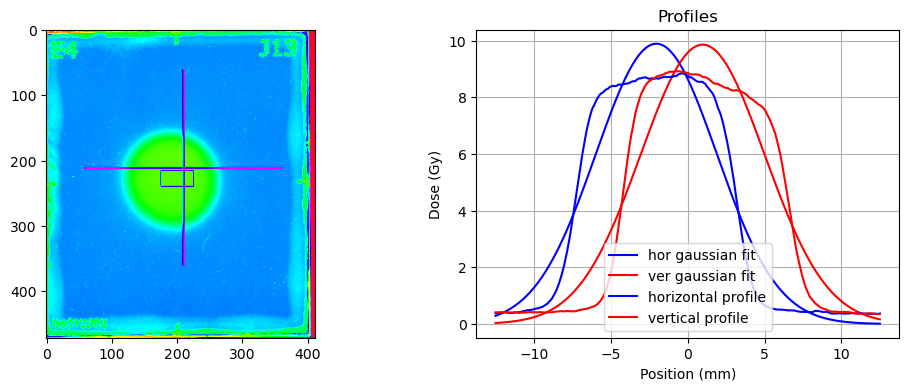

 Mean dose square :  8.42 Gy
 fit parameters hor:  a = 9.71 Gy, sigma = -4.04 mm, mu = -1.24 

 fit parameters ver:  a = 9.68 Gy, sigma = 4.14 mm, mu = 0.26 



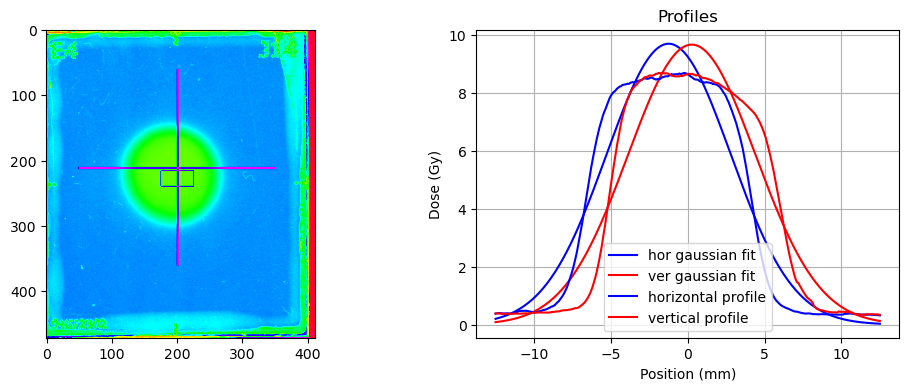

 Mean dose square :  8.13 Gy
 fit parameters hor:  a = 9.46 Gy, sigma = -4.03 mm, mu = -1.29 

 fit parameters ver:  a = 9.39 Gy, sigma = 4.1 mm, mu = -0.35 



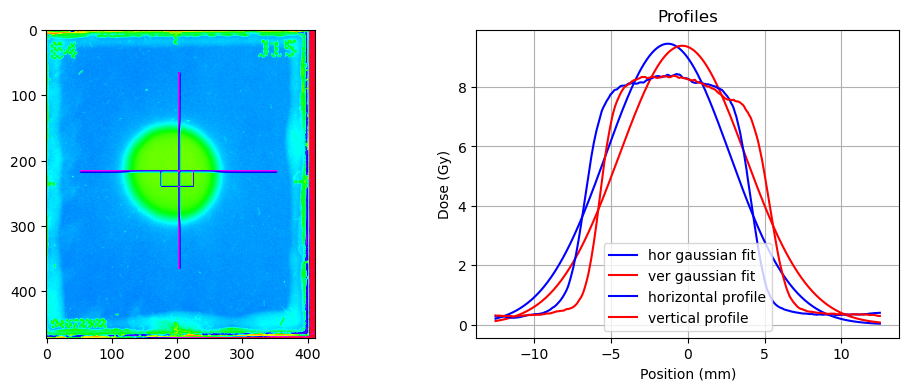

 Mean dose square :  8.33 Gy
 fit parameters hor:  a = 9.66 Gy, sigma = -4.03 mm, mu = -1.02 

 fit parameters ver:  a = 9.5 Gy, sigma = 4.16 mm, mu = 0.39 



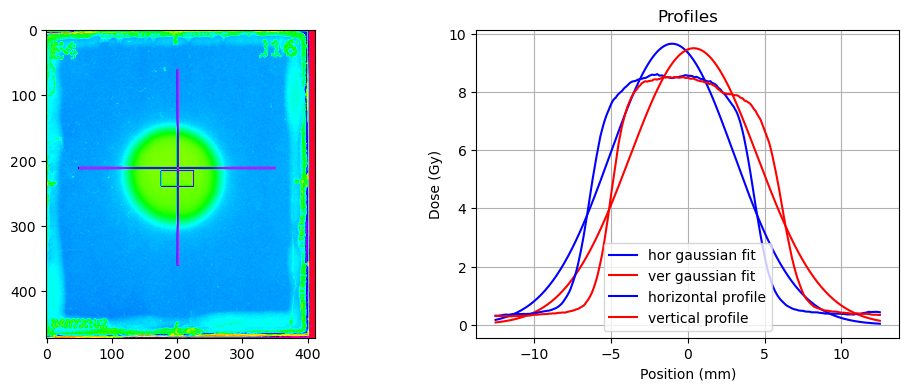

 Mean dose square :  8.22 Gy
 fit parameters hor:  a = 9.59 Gy, sigma = -4.06 mm, mu = -1.32 

 fit parameters ver:  a = 9.49 Gy, sigma = 4.12 mm, mu = -0.27 



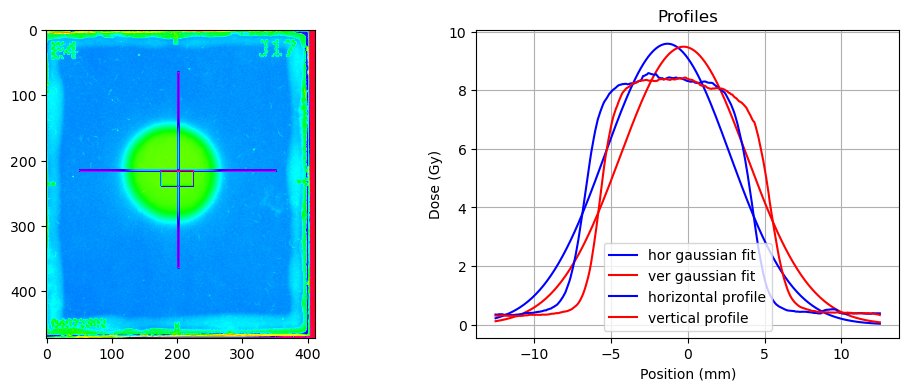

 Mean dose square :  8.35 Gy
 fit parameters hor:  a = 9.53 Gy, sigma = -4.07 mm, mu = -1.65 

 fit parameters ver:  a = 9.43 Gy, sigma = 4.1 mm, mu = 0.13 



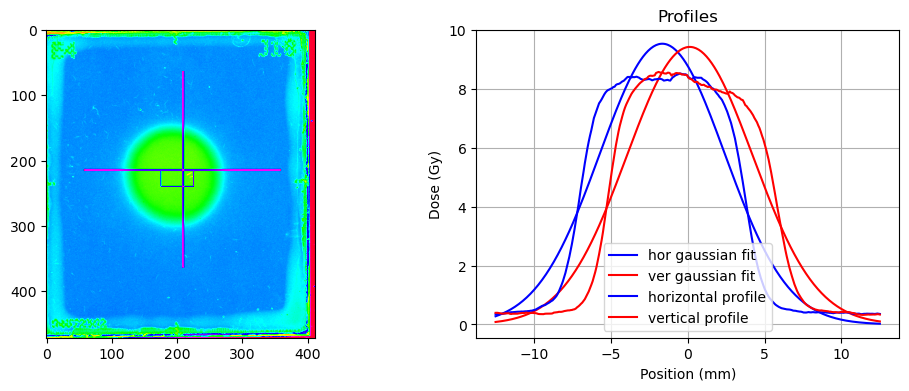

 Mean dose square :  10.65 Gy
 fit parameters hor:  a = 12.41 Gy, sigma = 4.03 mm, mu = -1.22 

 fit parameters ver:  a = 12.21 Gy, sigma = 4.14 mm, mu = 0.09 



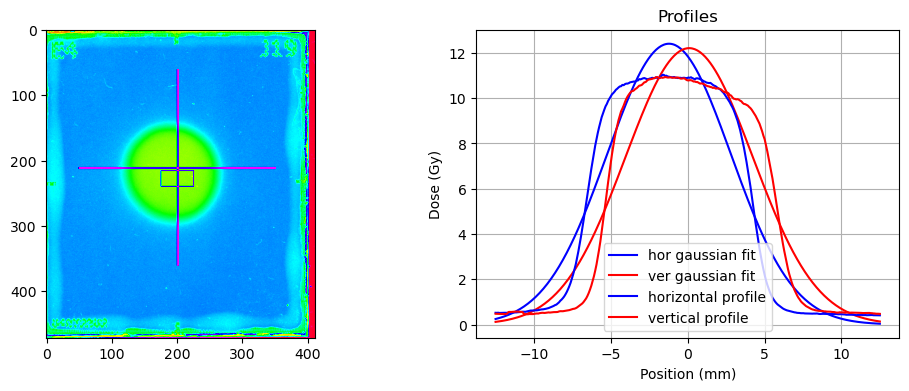

 Mean dose square :  10.67 Gy
 fit parameters hor:  a = 12.29 Gy, sigma = 4.06 mm, mu = -0.96 

 fit parameters ver:  a = 12.3 Gy, sigma = 4.18 mm, mu = 0.21 



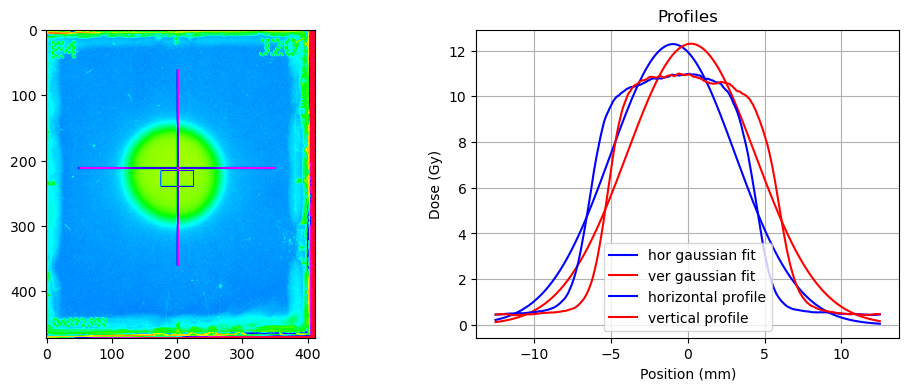

 Mean dose square :  10.33 Gy
 fit parameters hor:  a = 11.99 Gy, sigma = 4.03 mm, mu = -1.39 

 fit parameters ver:  a = 11.87 Gy, sigma = 4.09 mm, mu = -0.57 



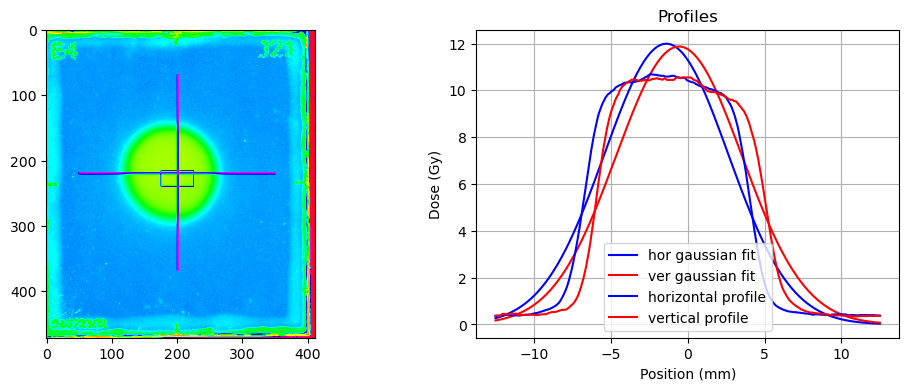

 Mean dose square :  9.85 Gy
 fit parameters hor:  a = 11.5 Gy, sigma = 4.04 mm, mu = -1.3 

 fit parameters ver:  a = 11.3 Gy, sigma = 4.16 mm, mu = 0.31 



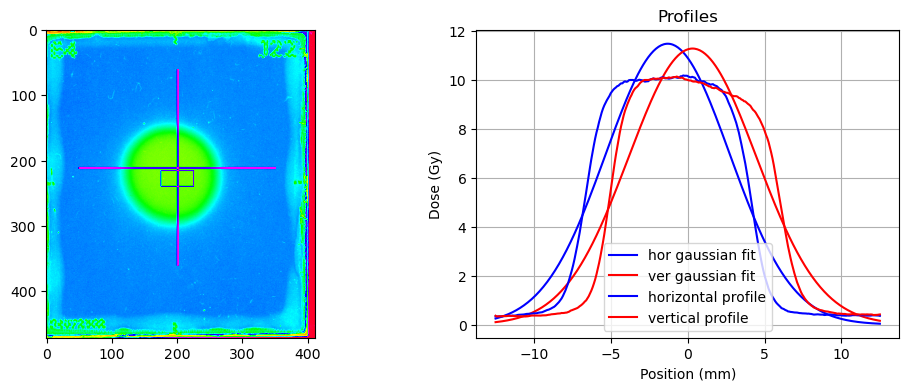

 Mean dose square :  9.91 Gy
 fit parameters hor:  a = 11.68 Gy, sigma = 4.01 mm, mu = -1.55 

 fit parameters ver:  a = 11.4 Gy, sigma = 4.08 mm, mu = 0.16 



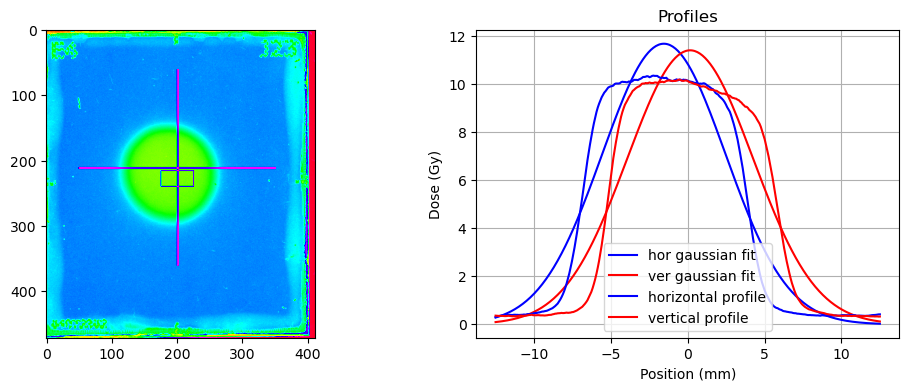

 Mean dose square :  10.05 Gy
 fit parameters hor:  a = 11.62 Gy, sigma = 4.05 mm, mu = -1.28 

 fit parameters ver:  a = 11.5 Gy, sigma = 4.16 mm, mu = 0.19 



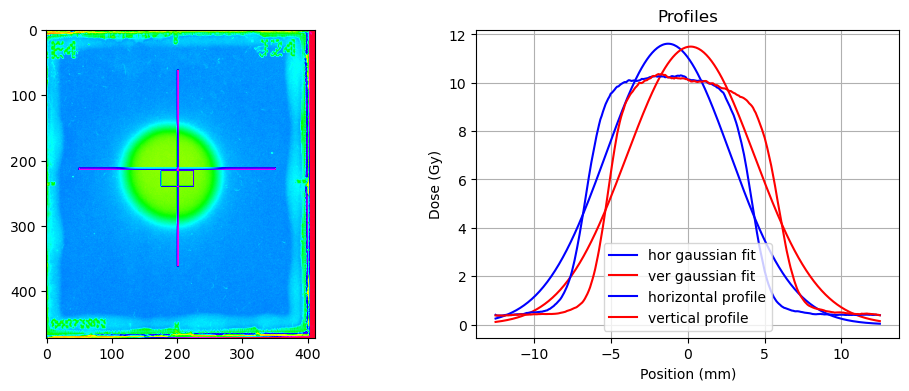

 Mean dose square :  13.12 Gy
 fit parameters hor:  a = 14.7 Gy, sigma = 3.65 mm, mu = -1.3 

 fit parameters ver:  a = 14.27 Gy, sigma = -3.88 mm, mu = 0.28 



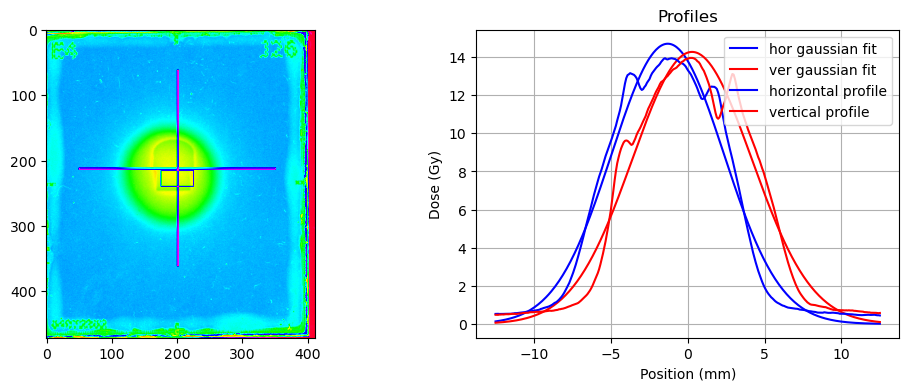

 Mean dose square :  11.11 Gy
 fit parameters hor:  a = 12.62 Gy, sigma = 3.57 mm, mu = -1.45 

 fit parameters ver:  a = 12.66 Gy, sigma = 3.73 mm, mu = 0.2 



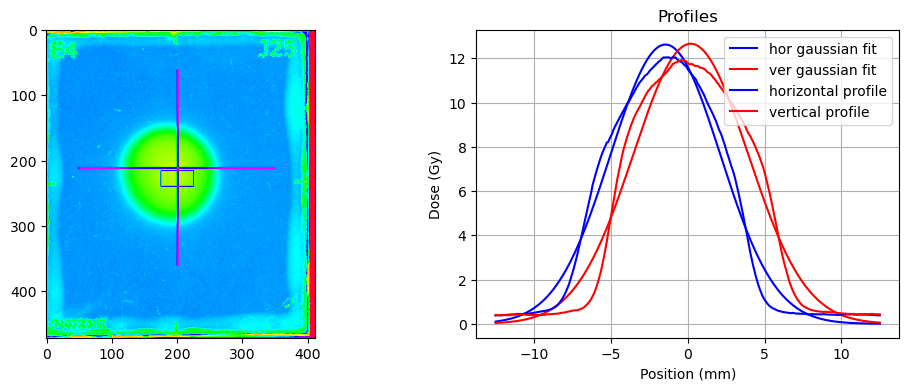

 Mean dose square :  10.17 Gy
 fit parameters hor:  a = 11.78 Gy, sigma = 4.05 mm, mu = -1.16 

 fit parameters ver:  a = 11.69 Gy, sigma = 4.2 mm, mu = -0.01 



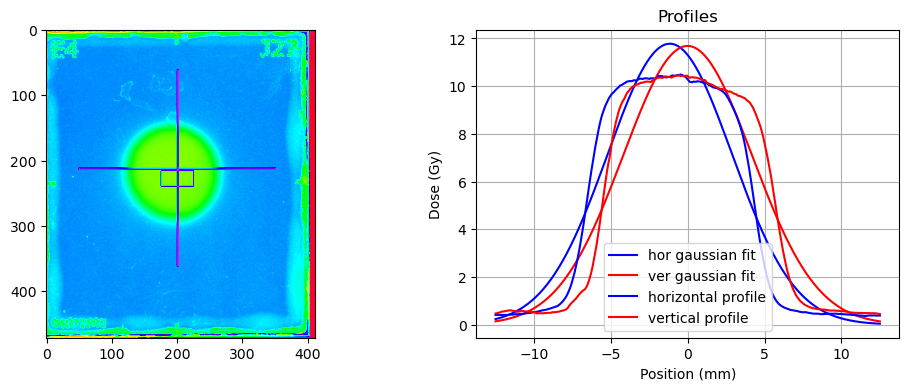

 Mean dose square :  10.76 Gy
 fit parameters hor:  a = 13.81 Gy, sigma = 3.99 mm, mu = -0.89 

 fit parameters ver:  a = 13.03 Gy, sigma = 4.23 mm, mu = 0.0 



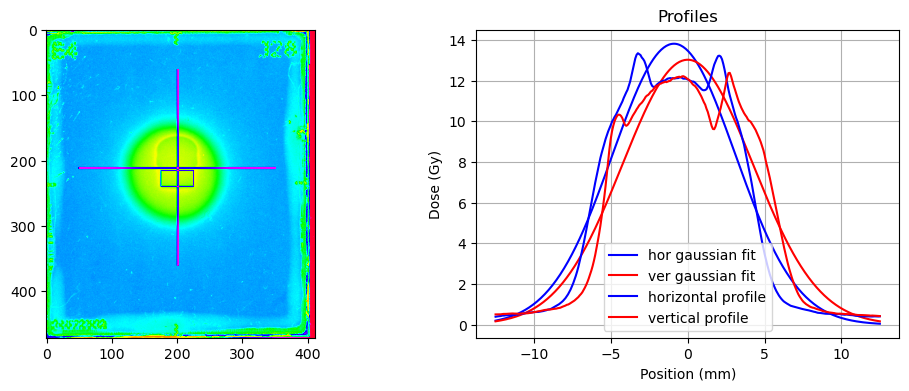

 Mean dose square :  0.23 Gy


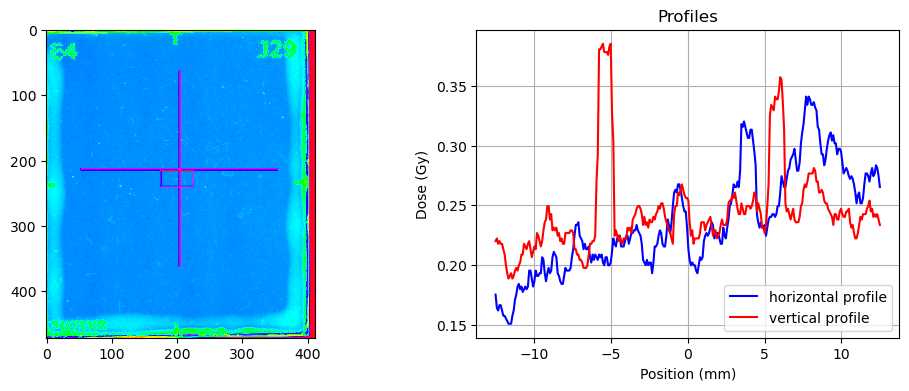

 Mean dose square :  0.24 Gy


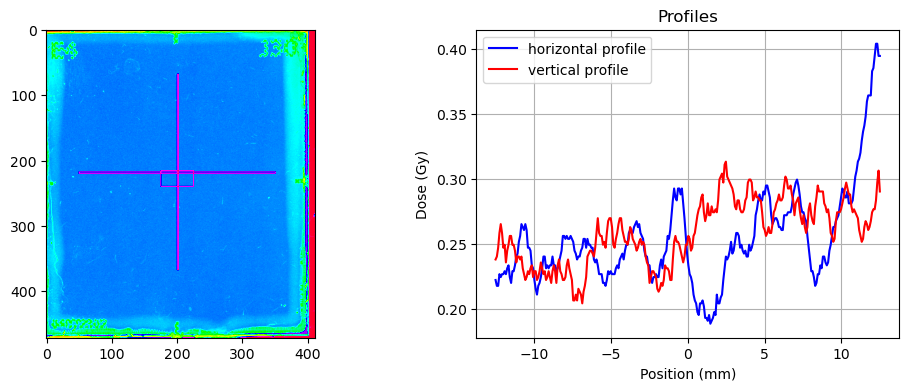

 Mean dose square :  0.28 Gy


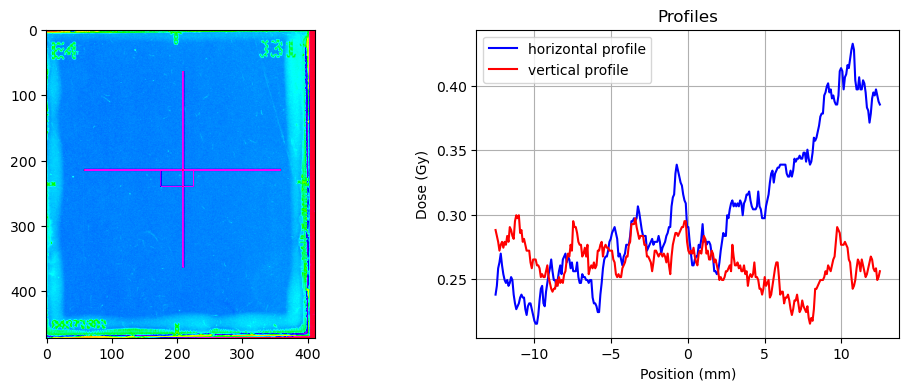

 Mean dose square :  0.32 Gy


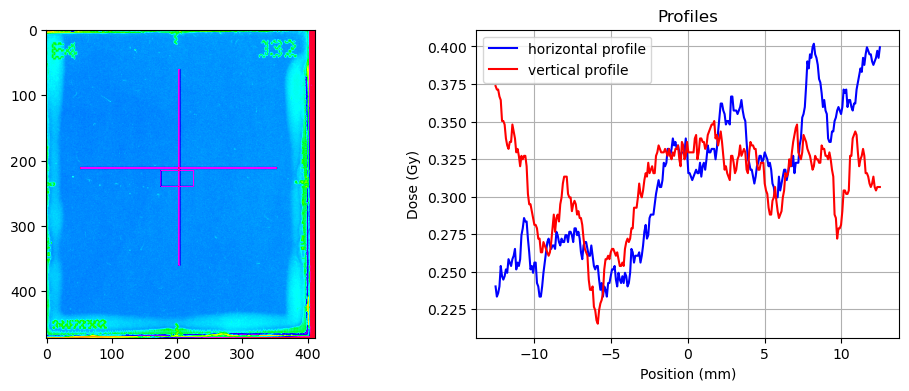

In [13]:
letter = "J"
channel = "G"

filenames = np.sort(os.listdir(f"HUG_study_2/ZFE_{letter}"))
filenames = filenames[1:]
dose = []
I = []

n=0
with open(f"HUG_study_2/measured_dose_{letter}.txt", "w") as text_file:
    text_file.write("Film \t Dose (Gy)\n")

    for i in filenames:    
    
        file = f'HUG_study_2/ZFE_{letter}/{i}'
        column0 = i.replace(".tif", "")
        
        image = cv2.imread(file)
        
        image_g = image[:, :, 1]

        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if channel == "G":
            negative_image = cv2.bitwise_not(image_g)
        elif channel == "RGB":
            negative_image = cv2.bitwise_not(image_gray)
        else:
            print("channel error")
            break
            
        #Gaussian blur to locate maximum intensity pixel

        image_blur = cv2.GaussianBlur(negative_image, (7, 7), 0)

        x_zoi, y_zoi = 200, 210

        zoi = image_blur[y_zoi:220, x_zoi:210]

        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(zoi)

        maxLoc_x = maxLoc[0] + x_zoi
        maxLoc_y = maxLoc[1] + y_zoi

        #square centered on the max pixel

        x, y, width, height = 175, 215, 50, 24
        #x, y, width, height = maxLoc_x-6, maxLoc_y-6, 12, 12

        area = negative_image[y:y+height, x:x+width]

        mean_intensity = np.mean(area)


        #horizontal slice
        x_hor, y_hor, width_hor, height_hor = maxLoc_x-150, maxLoc_y, 300, 2
        hor =  negative_image[y_hor:y_hor+height_hor, x_hor:x_hor+width_hor]

        #vertical slice
        x_ver, y_ver, width_ver, height_ver = maxLoc_x, maxLoc_y-150, 2, 300
        ver =  negative_image[y_ver:y_ver+height_ver, x_ver:x_ver+width_ver]
        
        #print("\033[1m Mean intensity square : \033[0m", mean_intensity)
        print(f"\033[1m Mean dose square : \033[0m", round(D(ItoOD(mean_intensity), *popt), 2), "Gy")
        
        #vertical and horizontal intensity per pixel length

        hor_intensity = []
        ver_intensity = []
        
        for i in range(1,width_hor):
            hor_intensity.append(np.mean(negative_image[y_hor:y_hor+height_hor, x_hor+i:x_hor+i+12]))   

        for i in range(1,height_ver):
            ver_intensity.append(np.mean(negative_image[y_ver+i:y_ver+i+12, x_ver:x_ver+width_ver]))

        hor_dose = []
        ver_dose = []

        for i in range(1, width_hor-1) :
            hor_dose.append(D(ItoOD(hor_intensity[i]), *popt))
            
        for i in range(1, height_ver-1):
            ver_dose.append(D(ItoOD(ver_intensity[i]), *popt))


        result = cv2.rectangle(negative_image, (x,y), (x+width, y+height), (0,255,0), 1)
        result_hor = cv2.rectangle(negative_image, (x_hor,y_hor), (x_hor+width_hor, y_hor+height_hor), (0,255,0), 1)
        result_ver = cv2.rectangle(negative_image, (x_ver,y_ver), (x_ver+width_ver, y_ver+height_ver), (0,255,0), 1)

        #Gaussian fit and display

        interval = np.linspace(-width_hor/2, width_hor/2, width_hor-2)
        interval_mm = interval/12  #Conversion en millimètres
        
        fig, axs = plt.subplots(1,2, figsize=(12, 4))
        axs = axs.ravel()
        
        def gauss(x, a, sigma, mu):
            return a*np.exp(-(x-mu)**2/(2*sigma**2))

        dose.append(round(D(ItoOD(mean_intensity), *popt), 2))
        
        if dose[n] > 1:
        
            popt_hor, pcov_hor = curve_fit(gauss, interval_mm, hor_dose)
            popt_ver, pcov_ver = curve_fit(gauss, interval_mm, ver_dose)

            a_hor, sigma_hor, mu_hor = popt_hor
            a_ver, sigma_ver, mu_ver = popt_ver

            axs[1].plot(interval_mm, gauss(interval_mm, *popt_hor), "blue",  label="hor gaussian fit")
            axs[1].plot(interval_mm, gauss(interval_mm, *popt_ver), "red",  label="ver gaussian fit")

            print(f"\033[1m fit parameters hor: \033[0m a = {round(a_hor, 2)} Gy, sigma = {round(sigma_hor, 2)} mm, mu = {round(mu_hor, 2)} \n")
            print(f"\033[1m fit parameters ver: \033[0m a = {round(a_ver, 2)} Gy, sigma = {round(sigma_ver, 2)} mm, mu = {round(mu_ver, 2)} \n")
        
        

        axs[0].imshow(result, cmap="hsv_r")

        axs[1].plot(interval_mm, hor_dose, color="blue", label="horizontal profile")
        axs[1].plot(interval_mm, ver_dose, color="red",  label="vertical profile")
        axs[1].set_xlabel("Position (mm)")
        axs[1].set_ylabel("Dose (Gy)")
        axs[1].set_title("Profiles")
        axs[1].grid(True)
        axs[1].legend()
        
        #print(maxLoc_x, maxLoc_y)
        #print(len(hor_dose), len(ver_dose))
        plt.show()
        
        #file
        I.append(mean_intensity)
        column1 = f"{round(D(ItoOD(mean_intensity), *popt), 2)}"
        #column2 = f"{round(sigma_hor, 2)}"
        
        line = f"{column0}\t {column1} \n"
        
        text_file.write(line)
        
        n+=1